In [1]:
from mpl_toolkits.basemap import Basemap
from pycm import ConfusionMatrix
from scipy import stats
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import dask.dataframe as dd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

sns.set()

In [2]:
app_events = dd.read_csv('talkingdata/app_events.csv')
app_labels = dd.read_csv('talkingdata/app_labels.csv')
events = dd.read_csv('talkingdata/events.csv')
train = dd.read_csv('talkingdata/gender_age_train.csv')
label_categories = dd.read_csv('talkingdata/label_categories.csv')
phone_brand_model = dd.read_csv('talkingdata/phone_brand_device_model.csv')

In [3]:
# ---------------------------------------------------------------------
# CREATE NEW DATAFRAME THAT CONTAINS TOTAL NUMBER OF APPS PER DEVICE  |
# --------------------------------------------------------------------

num_apps = events.groupby('device_id').first().reset_index().compute()
num_apps = dd.merge(num_apps, app_events[['event_id', 'app_id']], on = 'event_id').compute()

num_apps = num_apps.groupby('device_id')['app_id'].count().reset_index()
num_apps = dd.merge(num_apps, phone_brand_model, on = 'device_id', how = 'inner') 

num_apps = num_apps.rename(columns={'app_id': 'app_count'})

num_apps.head()

,device_id,app_count,phone_brand,device_model
0,-9222956879900151005,68,三星,Galaxy Note 2
1,-9222661944218806987,10,vivo,Y913
2,-9222399302879214035,43,小米,MI 3
3,-9221767098072603291,25,金立,GN151
4,-9221079146476055829,12,小米,MI 3


In [4]:
# ------------------------------------------------------------------------------
# CREATE ANOTHER DATAFRAME WITH GENDER INFO (GET FROM TRAINING SET DATAFRAME)  |
# -----------------------------------------------------------------------------

gender_info = dd.merge(train, num_apps, on = 'device_id', how = 'inner')
gender_info = gender_info.rename(columns={'index': 'device_id'}).compute()

gender_info.head()

,device_id,gender,age,group,app_count,phone_brand,device_model
0,-8260683887967679142,M,35,M32-38,53,小米,MI 2
1,7477216237379271436,F,37,F33-42,26,华为,荣耀6 plus
2,6352067998666467520,M,32,M32-38,19,华为,荣耀畅玩4X
3,8026504930081700361,M,25,M23-26,31,小米,MI 4
4,-7271319853104672050,M,27,M27-28,34,三星,Galaxy Note 3


## Inferential Stats

- **Null hypothesis:** There is no correlation between age and number of apps
- **Alternate hypothesis:** There is a correlation between age and number of apps
- **Significance level:** 0.05

In [5]:
# ------------------------------------
# FILTERING 'gender_info' BY GENDER  |
# -----------------------------------

male = gender_info[gender_info.gender == 'M']
female = gender_info[gender_info.gender == 'F']

# ------------------------------------------------------------
# GETTING CORRELATION COEFFICIENT & P-VALUE FOR EACH GENDER  |
# -----------------------------------------------------------

m_scipy_r, m_scipy_p = stats.pearsonr(male.age, male.app_count)
f_scipy_r, f_scipy_p = stats.pearsonr(female.age, female.app_count)

# ----------------
# PRINT RESULTS  |
# ---------------

print("Pearson correlation coefficient:", m_scipy_r)
print("Pearson p-value:", m_scipy_p, '\n')
print("Pearson correlation coefficient:", f_scipy_r)
print("Pearson p-value:", f_scipy_p)

Pearson correlation coefficient: 0.005390476428497901
Pearson p-value: 0.5745930595293385 

Pearson correlation coefficient: 0.01388534531993987
Pearson p-value: 0.2779909709621335


The p-values of both gender groups are greater than the chosen significance level. The null hypothesis is not rejected. Age has no correlation to the amount of apps installed on a device.

/Users/vwu/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


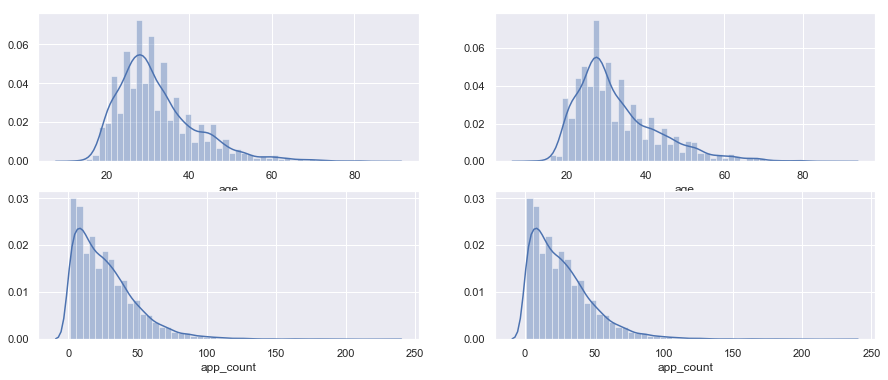

In [6]:
# -----------------------------------------------------------------
# PLOTTING DISTRIBUTION OF 'age' AND 'app_count' FOR EACH GENDER  |
# ----------------------------------------------------------------

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 6))
sns.distplot(male.age, ax = ax1)
sns.distplot(female.age, ax = ax2)
sns.distplot(male.app_count, ax = ax3)
sns.distplot(male.app_count, ax = ax4)
plt.show()

As can be seen from the distribution plots above, none of the distributions of each gender's 'age' and 'app_count' are normal. A nonparametric test is used to compare whether 'age' and 'app_count' between males and females have the same shape. Below, the Mann Whitney U test is performed.

- **Null hypothesis:** The two populations are equal/have the same shape
- **Alternate hypothesis:** There two populations are not equal/do not have the same shape
- **Significance level:** 0.05

In [7]:
# ---------------------
# MAN WHITNEY U TEST  |
# --------------------

u_stats_age, pval_age = stats.mannwhitneyu(male.age, female.age)
u_stats_app, pval_app = stats.mannwhitneyu(male.app_count, female.app_count)

# -----------------
# PRINT P-VALUES  |
# ----------------

print('Mann Whitney U p-value (age):', pval_age)
print('Mann Whitney U p-value (number of apps):', pval_app)

Mann Whitney U p-value (age): 0.05365886631268518
Mann Whitney U p-value (number of apps): 1.4108724351737035e-13


Based on the p-values, the distribution of *age* between Chinese men and women are similar.

However, it seems that the distribution of *number of apps* per device do NOT have the same shape. The p-value is significantly smaller than the significance level. This aligns with the observation earlier pointing out men seem to have more apps installed on their phones than women.